# GradCAM - Gradient Class Activation Map

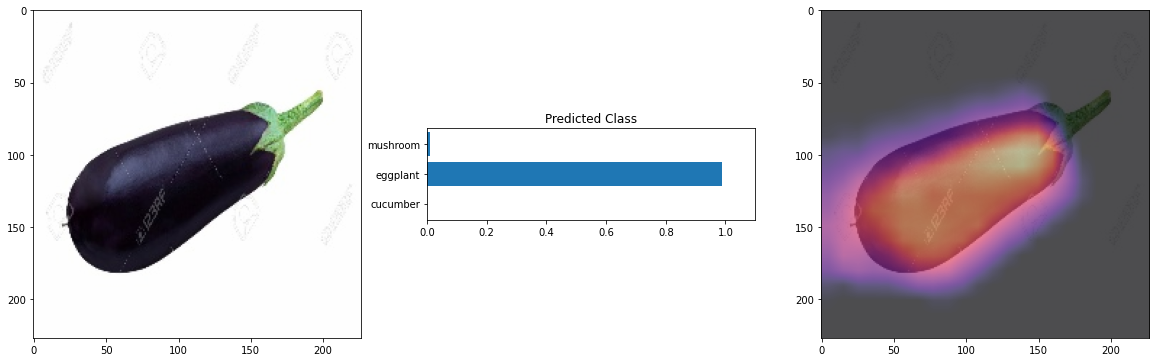

In [20]:
!git clone https://github.com/parth1620/GradCAM_Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...


remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 3.91 MiB/s, done.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pw2pcmq7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pw2pcmq7
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable


# Imports

In [59]:
import sys
sys.path.append('./GradCAM_Dataset')

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from GradCAM_Dataset import utils

# Configurations

In [61]:
csv_file = './GradCAM_Dataset/train.csv'
data_dir = './GradCAM_Dataset/'

device = 'cuda'
batch_size = 16
lr = 0.001
epochs = 20

In [62]:
data = pd.read_csv(csv_file)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [63]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [64]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_augs = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

# Load Image Dataset

In [65]:
utils.ImageDataset
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = data_dir)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'mushroom')

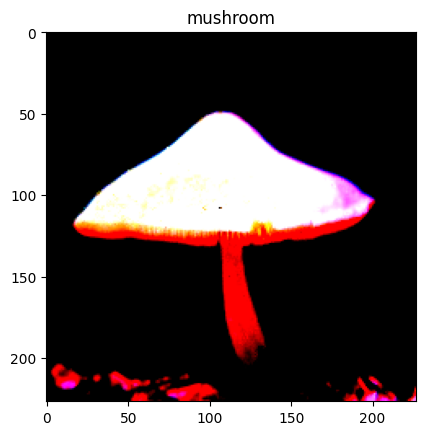

In [67]:
image, label = validset[5] # (c, h, w) -> (h, w, c) while plotting

class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label])

In [68]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [69]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [70]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [71]:
for images, labels in trainloader:
  break
print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

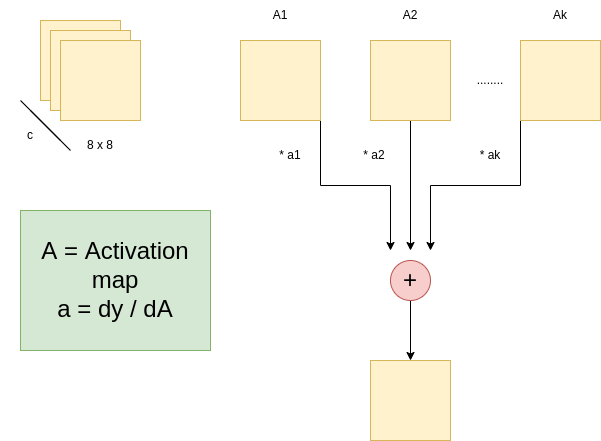

In [72]:
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
      )

    self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(6400, 2048),
      nn.ReLU(),
      nn.Linear(2048, 3)
    )
    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images) # activation maps

    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)
    return x

  def get_activation_gradients(self): # a1, a2, a3, ... ak
    return self.gradient

  def get_activation(self, x): # A1, A2, A3, ... AK
    return self.feature_extractor(x)


# we use the two above functions to find a1*A1 + a2*A2 + ... aK*AK


In [74]:
model = ImageModel()
# model.to(device)

# Create Train and Eval function

In [81]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    # images = images.to(device)
    # labels = labels.to(device)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [82]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    # images = images.to(device)
    # labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()

    total_loss += loss.item()
  return total_loss/len(dataloader)

# Training Loop

In [83]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [85]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")
  print(f"Epoch = {i+1}, train los = {train_loss}")

100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 1, train los = 0.10205793101340532


100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 2, train los = 0.16797395581379532


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Epoch = 3, train los = 0.09188206361141056


100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch = 4, train los = 0.07309537169630857


100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


Epoch = 5, train los = 0.04093523766805447


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Epoch = 6, train los = 0.15194226475432515


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Epoch = 7, train los = 0.07095964594336693


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch = 8, train los = 0.09275111353344982


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 9, train los = 0.07023428931465787


100%|██████████| 3/3 [00:00<00:00,  4.07it/s]


Epoch = 10, train los = 0.13307811961858534


100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


Epoch = 11, train los = 0.15117795048281552


100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch = 12, train los = 0.09016322998795659


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Epoch = 13, train los = 0.036181131051125706


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch = 14, train los = 0.026908326216289424


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch = 15, train los = 0.06695476617386475


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch = 16, train los = 0.06961238988951664


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch = 17, train los = 0.0784564356552437


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch = 18, train los = 0.0791325090394821


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epoch = 19, train los = 0.06547239667270333


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

Epoch = 20, train los = 0.06706455259773066


# Get GradCAM

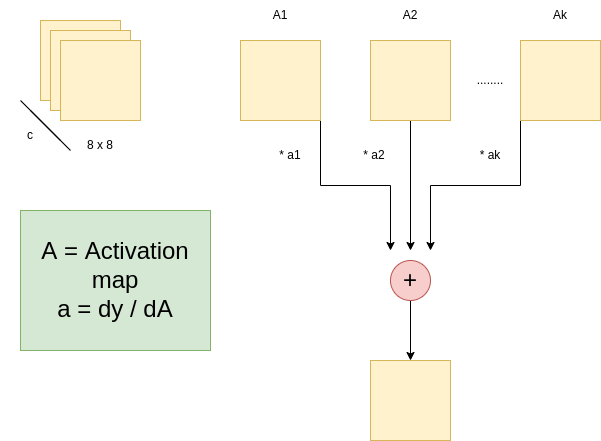

In [86]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) # a1, a2, ..., ak
  activations = model.get_activation(image).detach() # A1, A2, ..., AK

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap


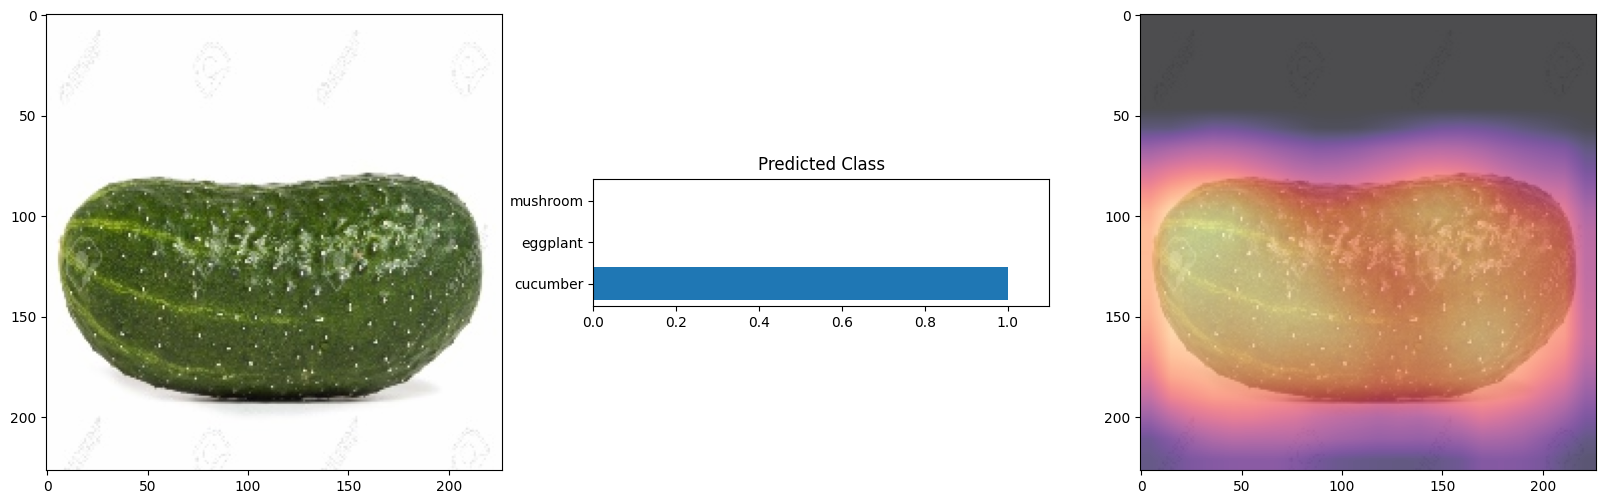

In [98]:
    image, label = validset[3]

    denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.unsqueeze(0)
    # image = image.to(device)
    pred = model(image)

    # print(label)
    # values of label are as follows:
    # cucumber = 0, # eggplant = 1, # mushroom = 2
    heatmap = get_gradcam(model, image, pred[0][label], size=227)
    utils.plot_heatmap(denorm_image, pred, heatmap)